# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 1 - Supervised Deep Learning - **Classification task**

Accomplished by Ali Bavarchee(1219425)
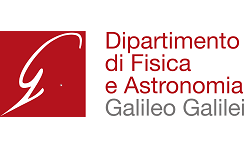




## General overview
* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of Zalando's article images (Fashion MNIST). 




## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.



# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

import time
import csv

import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

torch.manual_seed(777)

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Training device:', device)

Training device: cpu


Download the dataset:

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

How to get an image and the corresponding label:

SAMPLE AT INDEX 0
LABEL: 9


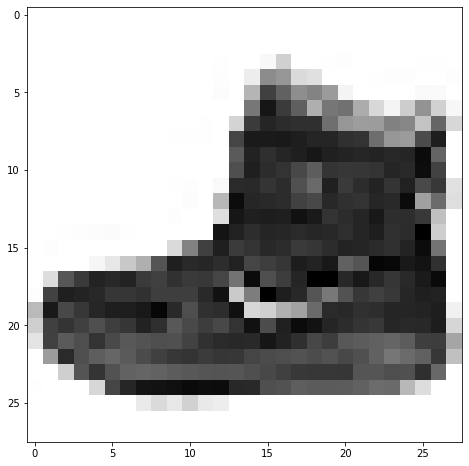

In [ ]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [ ]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [ ]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


In [ ]:
transf = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor()
])
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transf)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True,transform=transf)

In [ ]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

In [ ]:
train_dataset

Dataset shape: torch.Size([60000, 28, 28])


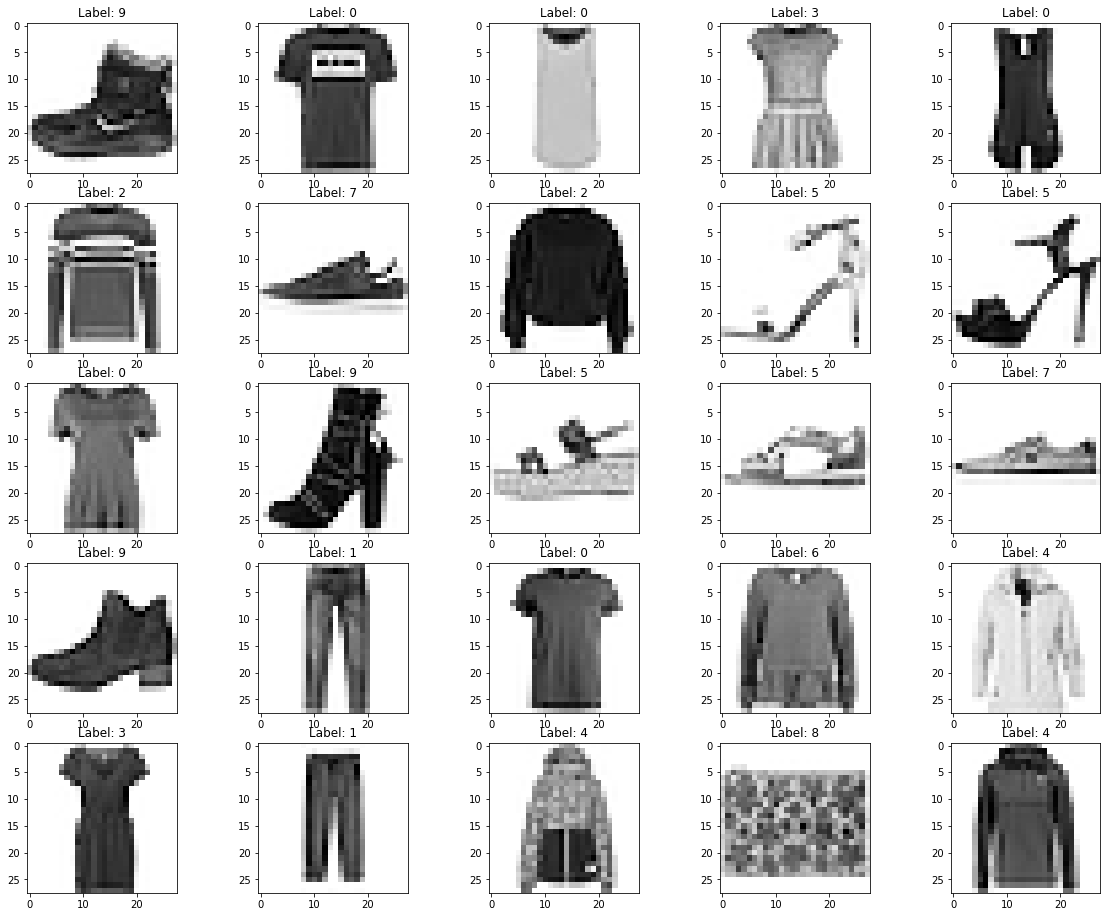

In [ ]:
print(f'Dataset shape: {train_dataset.data.shape}')

fig, ax = plt.subplots(5, 5, figsize=(20,16))
c = 0
for i in range(5):
  for j in range(5):
    image = train_dataset[c][0]
    label = train_dataset[c][1]
    ax[i, j].imshow(image, cmap='Greys')
    ax[i, j].set_title(f'Label: {label}')
    c += 1

plt.show()

### Hyperparameters

In [ ]:
# (0) Image size and number of classes
i_size = 28*28
n_classes = 10

# (1) Initial weights: default

# (2) Loss function
loss_function = nn.CrossEntropyLoss()

# (3) Optimizer: Adam

# (4) Activation function: ReLU (typically used with images)

# (6) Number of tested hyperparameters configurations
n_conf = 50

# (7) Batch size for training
batch_size_train = 128

# (8) Batch size for test
batch_size_test = 128

In [ ]:
# (9) Number of layers
N = [2, 4]

# (10) Neurons per layer
M = [4, 16, 32]

# (11) Learning rate
l_rate = [0.001, 0.0001]

# (12) Number of epochs
n_epochs = [20, 30, 40]

# (13) Values for weight decay
weights = [0, 0.0001, 0.01]

# (14) Values for dropout probability
dropouts = [0, 0.2, 0.4]

In [ ]:
class Net2(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, dropout_p):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        activation - Activation function
        dropout_p - Dropout probability
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        #self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
        self.out = nn.Linear(in_features=Nh2, out_features=No)

        self.act = nn.ReLU()

        self.dropout = nn.Dropout(dropout_p)

        print('Network initialized')
        
    def forward(self, x, additional_out=False):

        x = x.view(x.size(0), -1) # Reshaping from matrix to vector
        x = self.dropout(self.act(self.fc1(x)))
        x = self.dropout(self.act(self.fc2(x)))
        #x = self.dropout(self.act(self.fc3(x)))
        x = self.out(x)

        return x

In [ ]:
class Net4(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, Nh3, Nh4, No, dropout_p):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        Nh3 - Neurons in the 3rd hidden layer
        Nh4 - Neurons in the 4th hidden layer
        No - Output size
        activation - Activation function
        dropout_p - Dropout probability
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
        self.fc4 = nn.Linear(in_features=Nh3, out_features=Nh4)
        self.out = nn.Linear(in_features=Nh4, out_features=No)
        
        self.act = nn.ReLU()

        self.dropout = nn.Dropout(dropout_p)

        print('Network initialized')
        
    def forward(self, x, additional_out=False):

        x = x.view(x.size(0), -1) # Reshaping from matrix to
        x = self.dropout(self.act(self.fc1(x)))
        x = self.dropout(self.act(self.fc2(x)))
        x = self.dropout(self.act(self.fc3(x)))
        x = self.dropout(self.act(self.fc4(x)))
        x = self.out(x)

        return x

In [ ]:
def training_loop(net, num_epochs, train_dataloader, val_dataloader):
  """
  net - neural network
  num_epochs - number of epochs to train the network
  train_dataloader - training set
  val_dataloader - validation set
  """
  train_loss_log = []
  val_loss_log = []

  for epoch_num in range(0, num_epochs):
    # Print just some epochs
    if epoch_num % 5 == 0:
      print(f'......EPOCH {epoch_num+1}/{num_epochs}')

    ### TRAIN
    train_loss = []
    # Training mode (e.g. enable dropout)
    net.train()

    for sample_batched in train_dataloader:
      # Move data to device
      x_batched = sample_batched[0].to(device)
      label_batched = sample_batched[1].to(device)

      # Forward pass
      out = net(x_batched)

      # Compute loss
      loss = loss_function(out, label_batched)

      # Backpropagation
      net.zero_grad()
      loss.backward()

      # Update the weights
      optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)
    if epoch_num % 5 == 0:
      print(f'Train loss: {train_loss}')

    ### VALIDATION
    if len(val_dataloader) != 0:
      val_loss = []
      # Evaluation mode (e.g. disable dropout)
      net.eval()

      # Disable gradient tracking
      with torch.no_grad():

        for sample_batched in val_dataloader:
          # Move data to device
          x_batched = sample_batched[0].to(device)
          label_batched = sample_batched[1].to(device)

          # Forward pass
          out = net(x_batched)

          # Compute loss
          loss = loss_function(out, label_batched)

          # Save val loss for this batch
          loss_batch = loss.detach().cpu().numpy()
          val_loss.append(loss_batch)

        # Save average validation loss
        val_loss = np.mean(val_loss)
        val_loss_log.append(val_loss)
        if epoch_num % 5 == 0: 
          print(f'Val loss: {val_loss}')

  return [train_loss_log, val_loss_log]

In [ ]:
configurations = []
start = time.time()

for conf in range(1, n_conf+1):
  
  print('/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/')
  print(f'Configuration {conf}/{n_conf}:')
  
  # Init tunable parameters
  layers = np.random.choice(N)
  neurons = []
  [neurons.append(np.random.choice(M)) for i in range(layers)]
  l = np.random.choice(l_rate)
  epochs = np.random.choice(n_epochs)
  w = np.random.choice(weights)
  d_p = np.random.choice(dropouts)
  params = [layers, neurons, l, epochs, w, d_p]

  print(f'...Layers: {layers}')
  print(f'...Neurons per layer: {neurons}')
  print(f'...Learning rate: {l}')
  print(f'...Number of epochs: {epochs}')
  print(f'...Weight decay: {w}')
  print(f'...Dropout prob: {d_p}\n')

  # Initialize the network
  if layers == 4:  
    net = Net4(i_size, neurons[0], neurons[1], neurons[2], neurons[3], 10, d_p)
  elif layers == 3:
    net = Net2(i_size, neurons[0], neurons[1], neurons[2], 10, d_p)

  net.to(device)

  optimizer = optim.Adam(net.parameters(), lr=l, weight_decay=w)
  loss_function = nn.CrossEntropyLoss()

  train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
  val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

  # Training loop
  t_loss, v_loss = training_loop(net, epochs, train_dataloader, val_dataloader)

  configurations.append([t_loss[-1], v_loss[-1], params])
  print(f'\nFinal validation loss: {v_loss[-1]}')
  end = time.time()
  print(f'Elapsed time: {end-start}s')
  print('=========================================================================')

/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
Configuration 1/50:
...Layers: 2
...Neurons per layer: [32, 4]
...Learning rate: 0.001
...Number of epochs: 20
...Weight decay: 0.0001
...Dropout prob: 0.2

......EPOCH 1/20
Train loss: 0.8156068921089172
Validation loss: 0.6324750781059265
......EPOCH 6/20
Train loss: 0.4792177081108093
Validation loss: 0.4662174880504608
......EPOCH 11/20
Train loss: 0.4088345766067505
Validation loss: 0.44675588607788086
......EPOCH 16/20
Train loss: 0.36785218119621277
Validation loss: 0.38972777128219604

Final validation loss: 0.4014451503753662
Elapsed time: 229.94386196136475s
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
Configuration 2/50:
...Layers: 2
...Neurons per layer: [32, 32]
...Learning rate: 0.0001
...Number of epochs: 30
...Weight decay: 0.01
...Dropout prob: 0.0

......EPOCH 1/30
Train loss: 0.314480185508728
Validation loss: 0.3632332682609558
......EPOCH 6/30
Train loss: 0.40236273407936096
Validation loss: 0.42365819215774536
...

In [ ]:
configurations = []
start = time.time()

for conf in range(1, n_conf+1):
  
  print('/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/')
  print(f'Configuration {conf}/{n_conf}:')
  
  # Init tunable parameters
  layers = np.random.choice(N)
  neurons = []
  [neurons.append(np.random.choice(M)) for i in range(layers)]
  l = np.random.choice(l_rate)
  epochs = np.random.choice(n_epochs)
  w = np.random.choice(weights)
  d_p = np.random.choice(dropouts)
  params = [layers, neurons, l, epochs, w, d_p]

  print(f'...Layers: {layers}')
  print(f'...Neurons per layer: {neurons}')
  print(f'...Learning rate: {l}')
  print(f'...Number of epochs: {epochs}')
  print(f'...Weight decay: {w}')
  print(f'...Dropout prob: {d_p}\n')

  # Initialize the network
  if layers == 4:  
    net = Net4(i_size, neurons[0], neurons[1], neurons[2], neurons[3], 10, d_p)
  elif layers == 2:
    net = Net2(i_size, neurons[0], neurons[1], 10, d_p)

  net.to(device)

  optimizer = optim.Adam(net.parameters(), lr=l, weight_decay=w)
  loss_function = nn.CrossEntropyLoss()

  train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=2)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size_train, shuffle=True, num_workers=2)

  # Training loop
  t_loss, v_loss = training_loop(net, epochs, train_dataloader, val_dataloader)

  configurations.append([t_loss[-1], v_loss[-1], params])
  print(f'\nFinal validation loss: {v_loss[-1]}')
  end = time.time()
  print(f'wall time: {end-start}s')
  print('=========================================================================')

/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
Configuration 1/50:
...Layers: 2
...Neurons per layer: [32, 4]
...Learning rate: 0.001
...Number of epochs: 40
...Weight decay: 0.0
...Dropout prob: 0.4

Network initialized
......EPOCH 1/40
Train loss: 1.8208110332489014
Val loss: 1.2729568481445312
......EPOCH 6/40
Train loss: 1.3838920593261719
Val loss: 0.8706042170524597
......EPOCH 11/40
Train loss: 1.3338366746902466
Val loss: 0.8108631372451782
......EPOCH 16/40
Train loss: 1.3109601736068726
Val loss: 0.7704970240592957
......EPOCH 21/40
Train loss: 1.2935136556625366
Val loss: 0.759587287902832
......EPOCH 26/40
Train loss: 1.280312418937683
Val loss: 0.7408207058906555
......EPOCH 31/40
Train loss: 1.2691279649734497
Val loss: 0.7599522471427917
......EPOCH 36/40
Train loss: 1.2730486392974854
Val loss: 0.7502285242080688

Final validation loss: 0.7343161106109619
wall time: 244.9264416694641s
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
Configuration 2/50:
...Layers: 2
...N

In [ ]:
# opening the csv file in 'w+' mode 
file = open('config_cls.csv', 'w+', newline ='') 

# Header of the file
with file:     
  write = csv.writer(file)
  write.writerows(configurations)    

df = pd.read_csv('config_cls.csv')
df.columns = ['train_loss','validation_loss','parameters']
df.to_csv('config_clss.csv')

In [ ]:
configs = pd.read_csv('config_cls.csv')

In [ ]:
display(best_configs)

,Unnamed: 0,train_loss,validation_loss,parameters
8,8,0.416366,0.369050,"[2, [32, 16], 0.001, 30, 0.0, 0.2]"
37,37,0.319458,0.379771,"[2, [16, 16], 0.001, 30, 0.0001, 0.0]"
26,26,0.296369,0.381935,"[2, [16, 32], 0.001, 40, 0.0001, 0.0]"
27,27,0.535231,0.399417,"[2, [32, 32], 0.001, 40, 0.0001, 0.4]"
23,23,0.389887,0.404327,"[2, [32, 32], 0.0001, 30, 0.0001, 0.0]"


In [ ]:
configs = pd.read_csv('config_clss.csv')

configs = configs.sort_values('validation_loss')
top_n = 5
best_configs = configs.head(top_n)

display(best_configs)

# v_losses = configs['validation_loss']
# v_losses = np.array(v_losses)

n_layers = []
neurons = []
l_rate = []
n_epochs = []
weight_d = []
drop_probs = []

for i in np.array(best_configs['parameters']):
  i = i[1:-1]
  i = i.split(sep=',')
  n_layers.append((int)(i[0]))
  tmp = []
  for j in range(n_layers[-1]):
    if j == 0:
      tmp.append((int)((i[1+j])[2:]))
    elif (j == 2 and n_layers[-1] == 3) or (j == 3 and n_layers[-1] == 4):
      tmp.append((int)((i[1+j])[1:-1]))
    else:
      tmp.append((int)((i[1+j])[1:-1]))
  neurons.append(tmp)
  
  l_rate.append((float)(i[2+j]))
  n_epochs.append((int)(i[3+j]))
  weight_d.append((float)(i[4+j]))
  drop_probs.append((float)(i[5+j]))

,Unnamed: 0,train_loss,validation_loss,parameters
8,8,0.416366,0.369050,"[2, [32, 16], 0.001, 30, 0.0, 0.2]"
37,37,0.319458,0.379771,"[2, [16, 16], 0.001, 30, 0.0001, 0.0]"
26,26,0.296369,0.381935,"[2, [16, 32], 0.001, 40, 0.0001, 0.0]"
27,27,0.535231,0.399417,"[2, [32, 32], 0.001, 40, 0.0001, 0.4]"
23,23,0.389887,0.404327,"[2, [32, 32], 0.0001, 30, 0.0001, 0.0]"


In [ ]:
display(best_configs)

,Unnamed: 0,train_loss,validation_loss,parameters
8,8,0.416366,0.369050,"[2, [32, 16], 0.001, 30, 0.0, 0.2]"
37,37,0.319458,0.379771,"[2, [16, 16], 0.001, 30, 0.0001, 0.0]"
26,26,0.296369,0.381935,"[2, [16, 32], 0.001, 40, 0.0001, 0.0]"
27,27,0.535231,0.399417,"[2, [32, 32], 0.001, 40, 0.0001, 0.4]"
23,23,0.389887,0.404327,"[2, [32, 32], 0.0001, 30, 0.0001, 0.0]"


In [ ]:
global_t_losses = []
global_v_losses = []
wall_time = []

for conf in range(1, top_n+1):
  
  print('/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/')
  print(f'Configuration {conf}/{top_n}:')
  
  # Init tunable parameters
  layers = n_layers[conf-1]
  neur = neurons[conf-1]
  l = l_rate[conf-1]
  epochs = n_epochs[conf-1]
  w = weight_d[conf-1]
  d_p = drop_probs[conf-1]
  params = [layers, neur, l, epochs, w, d_p]

  print(f'...Layers: {layers}')
  print(f'...Neurons per layer: {neur}')
  print(f'...Learning rate: {l}')
  print(f'...NUmber of epochs: {epochs}')
  print(f'...Weight decay: {w}')
  print(f'...Dropout prob: {d_p}\n')

  start = time.time()

  # Initialize the network
  if layers == 4:  
    net = Net4(i_size, neur[0], neur[1], neur[2], neur[3], 10, d_p)
  elif layers == 3:
    net = Net3(i_size, neur[0], neur[1], neur[2], 10, d_p)

  net.to(device)

  optimizer = optim.Adam(net.parameters(), lr=l, weight_decay=w)
  loss_function = nn.CrossEntropyLoss()

  train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=2)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size_train, shuffle=True, num_workers=2)

  # Training loop
  t_loss, v_loss = training_loop(net, epochs, train_dataloader, val_dataloader)
  global_t_losses.append(t_loss)
  global_v_losses.append(v_loss)

  print(f'\nFinal val loss: {v_loss[-1]}')
  end = time.time()
  wall_time.append(end-start)
  print(f'execution time: {end-start}s')
  print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')

/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
Configuration 1/5:
...Layers: 2
...Neurons per layer: [32, 16]
...Learning rate: 0.001
...NUmber of epochs: 30
...Weight decay: 0.0
...Dropout prob: 0.2

......EPOCH 1/30
Train loss: 1.7214365005493164
Val loss: 1.3010016679763794
......EPOCH 6/30
Train loss: 1.729565978050232
Val loss: 1.3102842569351196
......EPOCH 11/30
Train loss: 1.7221647500991821
Val loss: 1.2987576723098755
......EPOCH 16/30
Train loss: 1.7207930088043213
Val loss: 1.3036853075027466
......EPOCH 21/30
Train loss: 1.7176045179367065
Val loss: 1.2949180603027344
......EPOCH 26/30
Train loss: 1.714825987815857
Val loss: 1.2845836877822876

Final val loss: 1.2951561212539673
execution time: 204.232990026474s
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
Configuration 2/5:
...Layers: 2
...Neurons per layer: [16, 16]
...Learning rate: 0.001
...NUmber of epochs: 30
...Weight decay: 0.0001
...Dropout prob: 0.0

......EPOCH 1/30
Train loss: 1.71361529827117

In [ ]:
wall_time = np.array(wall_time)
global_t_losses = np.array(global_t_losses, dtype='object')
global_v_losses = np.array(global_v_losses, dtype='object')

file = open('training_loss.csv', 'w+', newline ='') 

with file:     
  write = csv.writer(file)
  write.writerows(global_t_losses)    

file = open('val_loss.csv', 'w+', newline ='') 

with file:     
  write = csv.writer(file)
  write.writerows(global_v_losses)   

np.savetxt('wall_time.csv', wall_time, delimiter=',')

In [ ]:
train_l = []
val_l = []
times = []

with open('training_loss.csv', newline='') as f:
    reader = csv.reader(f)
    train_l = list(reader)

with open('val_loss.csv', newline='') as f:
    reader = csv.reader(f)
    val_l = list(reader)

with open('wall_time.csv', newline='') as f:
    reader = csv.reader(f)
    times = list(reader)

# Cast from string to float
for j in range(0, len(train_l)):
  for i in range(0, len(train_l)):
    train_l[j][i] = (float)(train_l[j][i])
  train_l[j] = np.array(train_l[j], dtype='float')

train_l = np.array(train_l, dtype='object')

for j in range(0, len(val_l)):
  for i in range(0, len(val_l[j])):
    val_l[j][i] = (float)(val_l[j][i])
  val_l[j] = np.array(val_l[j], dtype='float')

val_l = np.array(val_l, dtype='object')

for j in range(0, len(times)):
  for i in range(0, len(times[j])):
    times[j][i] = (float)(times[j][i])

times = np.reshape(np.array(times), (np.array(times).shape[0]))

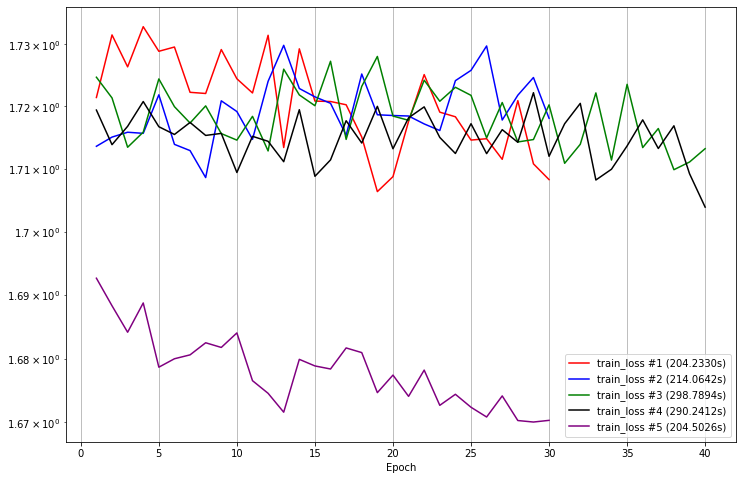

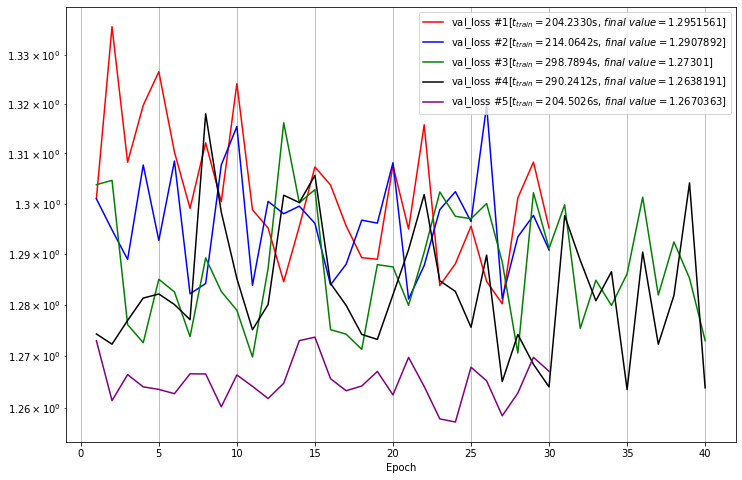

In [ ]:
plt.figure(figsize=(12,8))

colormap = ['red', 'blue', 'green', 'black', 'purple']

for j in range(0, len(train_l)):
	tmp = f'train_loss #{j+1} ({times[j]:.4f}s)'
	plt.semilogy(range(1, len(train_l[j])+1), train_l[j], color=colormap[j], label=tmp)

plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(12,8))

for j in range(0, len(val_l)):
	tmp = f'val_loss #{j+1}' + '[$t_{train}=$' + f'{times[j]:.4f}s, $final\ value =${(val_l[j])[-1]}]'
	plt.semilogy(range(1, len(val_l[j])+1), val_l[j], color=colormap[j], label=tmp)

plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Re-load the dataset

transf = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor()
])

train_dataset = torchvision.FashionMNIST('classifier_data', train=True, download=True, transform=transf)
test_dataset = torchvision.FashionMNIST('classifier_data', train=False, download=True, transform=transf)

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Training device:', device)

Training device: cpu


In [ ]:
# Best model hyperparameters
layers = 3
neurons = [64, 64, 32]
l = 0.001
epochs = 30
w = 0.0001
d_p = 0
params = [layers, neurons, l, epochs, w, d_p]

# # Second best model hyperparameters
# layers = 3
# neurons = [64, 64, 32]
# l = 0.001
# epochs = 30
# w = 0.0001
# d_p = 0
# params = [layers, neurons, l, epochs, w, d_p]
    
# Initialize the network
if layers == 4:  
    net = Net4(i_size, neurons[0], neurons[1], neurons[2], neurons[3], 10, d_p)
elif layers == 2:
    net = Net2(i_size, neurons[0], neurons[1], 10, d_p)
      
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=l, weight_decay=w)
loss_function = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=2)

print('=====================================================')
    
# Training loop
t_loss, _ = training_loop(net, epochs, train_dataloader, [])


print(f'Final training loss: {t_loss[-1]}')

......EPOCH 1/30
Train loss: 1.705492615699768
......EPOCH 6/30
Train loss: 1.7129698991775513
......EPOCH 11/30
Train loss: 1.6923339366912842
......EPOCH 16/30
Train loss: 1.6907553672790527
......EPOCH 21/30
Train loss: 1.6989535093307495
......EPOCH 26/30
Train loss: 1.705700397491455
Final training loss: 1.6978453397750854


In [ ]:
net_state_dict = net.state_dict()
torch.save(net_state_dict, 'classifi_model.torch')

In [ ]:
# Load the model if needed
if layers == 4:  
    net = Net4(i_size, neurons[0], neurons[1], neurons[2], neurons[3], 10, d_p)
elif layers == 2:
    net = Net2(i_size, neurons[0], neurons[1], 10, d_p)
    
net.lead_state_dict(torch.load('classifi_model'))

In [ ]:
# Network input (the test set)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True, num_workers=2)

# Network output
predictions = []
net.to(device)
net.eval()
with torch.no_grad():
  for sample_batched in test_dataloader:
    # Move data to device
    x_batched = sample_batched[0].to(device)
    label_batched = sample_batched[1].to(device)

    # Forward pass
    out = net(x_batched).squeeze().cpu()
    predictions.append([sample_batched, F.softmax(out, dim=1)])

In [ ]:
y_true = []
y_pred = []
images = []
y_pred_prob = []

for batch in predictions:
  # batch[0][0] : (128) images in one batch
  # batch[0][1] : (128) ground truths of the batch
  # batch[1] : (128) predictions for the batch
  for (img, gt, pred) in zip(batch[0][0], batch[0][1], batch[1]):
    y_pred.append((int)(np.argmax(pred)))
    y_true.append((int)(gt))
    images.append(np.array(img))
    y_pred_prob.append(pred)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
images = np.array(images)
y_pred_prob = np.array(y_pred_prob, dtype='object')

corr_pred = (y_true == y_pred)
print(f'Number of correct predictions: {sum(corr_pred)}/{len(corr_pred)} ({100 * sum(corr_pred)/len(corr_pred)}%)\n')

prec, rec, fscore, supp = precision_recall_fscore_support(y_true, y_pred)

print('F1 score')
for i in range(n_classes):
  print(f'Class {i}: {fscore[i]:.4f}')

print('\nConfusion matrix (row - true, column - predicted):')
print(confusion_matrix(y_true, y_pred))

Number of correct predictions: 8888/10000 (88.88%)

F1 score
Class 0: 0.8296
Class 1: 0.9790
Class 2: 0.8243
Class 3: 0.8900
Class 4: 0.8099
Class 5: 0.9714
Class 6: 0.7124
Class 7: 0.9490
Class 8: 0.9715
Class 9: 0.9561

Confusion matrix (row - true, column - predicted):
[[818   1  22  21   5   2 122   0   9   0]
 [  4 978   3   9   2   0   3   0   1   0]
 [ 12   1 854   7  54   0  70   0   2   0]
 [ 27  13   7 874  30   0  47   0   2   0]
 [  0   1 101  28 769   0  98   0   3   0]
 [  0   0   0   0   0 967   0  21   0  12]
 [108   3  80  17  38   0 743   0  11   0]
 [  0   0   0   0   0  11   0 967   0  22]
 [  3   1   5   8   1   5   2   4 971   0]
 [  0   0   0   0   0   6   1  46   0 947]]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
y_true_c = y_true[corr_pred]
y_pred_c = y_pred[corr_pred]
images_c = images[corr_pred]
y_pred_prob_c = y_pred_prob[corr_pred]

wrong_pred = (y_true != y_pred)
y_true_w = y_true[wrong_pred]
y_pred_w = y_pred[wrong_pred]
images_w = images[wrong_pred]
y_pred_prob_w = y_pred_prob[wrong_pred]

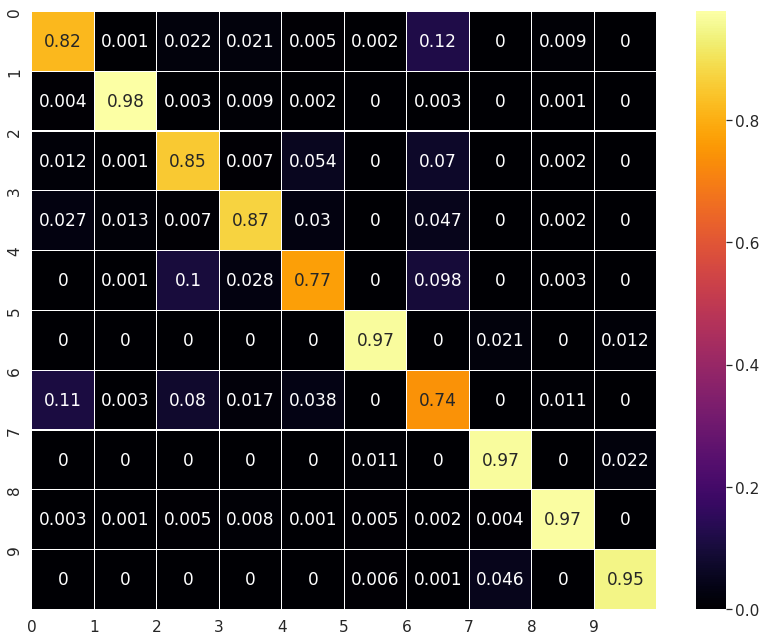

In [ ]:
con_mat = con_mat_cnn.astype('float') / con_mat_cnn.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(14,11))
sns.set(font_scale=1.4)
sns.heatmap(con_mat, annot=True, annot_kws={'size': 17}, cmap='inferno', linewidths=0.2)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.show()

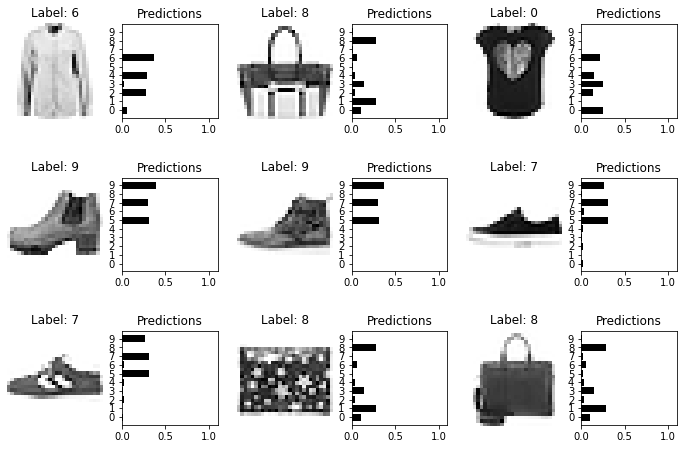

In [ ]:
fig, ax = plt.subplots(3, 6, figsize=(12,8))

for i in range(3):
  for j in [0, 2, 4]:
    index = np.random.randint(0, len(y_true_c))
    ax[i, j].imshow(images_c[index].squeeze(), cmap='Greys')
    ax[i, j].set_title(f'Label: {y_true_c[index]}')
    ax[i, j].axis('off')
    ax[i, j+1].barh(np.arange(10), y_pred_prob_c[index], color='black')
    ax[i, j+1].set_aspect(0.1)
    ax[i, j+1].set_yticks(np.arange(10))
    ax[i, j+1].set_yticklabels(np.arange(10))
    ax[i, j+1].set_title('Predictions')
    ax[i, j+1].set_xlim(0, 1.1)

plt.show()

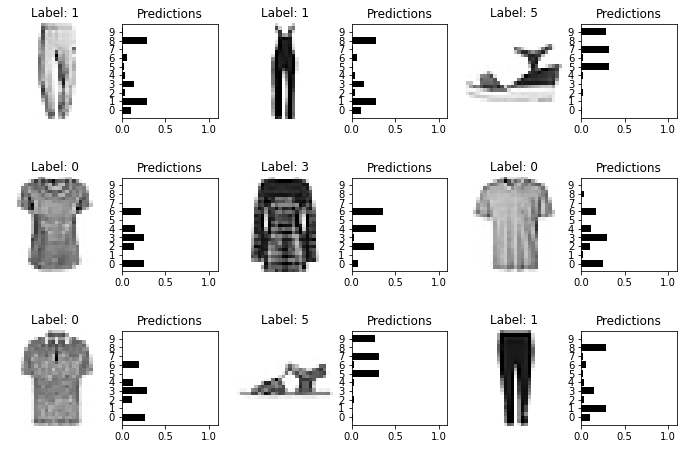

In [ ]:
fig, ax = plt.subplots(3, 6, figsize=(12,8))

for i in range(3):
  for j in [0, 2, 4]:
    index = np.random.randint(0, len(y_true_w))
    ax[i, j].imshow(images_w[index].squeeze(), cmap='Greys')
    ax[i, j].set_title(f'Label: {y_true_w[index]}')
    ax[i, j].axis('off')
    ax[i, j+1].barh(np.arange(10), y_pred_prob_w[index], color='black')
    ax[i, j+1].set_aspect(0.1)
    ax[i, j+1].set_yticks(np.arange(10))
    ax[i, j+1].set_yticklabels(np.arange(10))
    ax[i, j+1].set_title('Predictions')
    ax[i, j+1].set_xlim(0, 1.1)

plt.show()

In [ ]:
# (0) Image size and number of classes
i_size = 28*28
n_classes = 10

# (1) Initial weights: default

# (2) Loss function
loss_function = nn.CrossEntropyLoss()

# (3) Optimizer: Adam

# (4) Activation function: ReLU (typically used with images)

# (5) Batch size for training
batch_size_train = 128

# (6) Batch size for test
batch_size_test = 128

# (7) Number of epochs
epochs = 40

# (8) Learning rate
l_rate = 0.001

# (9) Weight decay
w_decay = 0.001

In [ ]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Activation function
        self.act = nn.ReLU()
        
        ### Convolutional section
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2)
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        # First linear layer
        self.fc1 = nn.Linear(288, 64)
        
        # Second linear layer
        self.fc2 = nn.Linear(64, 32)

        # Output layer
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x, additional_output=False):
        
        # Convolutions
        x = self.act(self.conv1(x))
        x1 = x
        x = self.act(self.conv2(x))
        x2 = x
        x = self.act(self.conv3(x))
        x3 = x

        # Flatten
        x = self.flatten(x)
        
        # Linear layers
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))

        if additional_output:
          return x, x1, x2, x3
        else:
          return x

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Training device:', device)

In [ ]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

In [ ]:
print('---------------------------------------')
start = time.time()

# Initialize the network
net = CNN()
net.to(device)

optimizer = optim.Adam(net.parameters(), lr=l_rate, weight_decay=w_decay)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size_train, shuffle=True, num_workers=2)

# Training loop
t_loss, v_loss = training_loop(net, epochs, train_dataloader, val_dataloader)

print(f'\nFinal validation loss: {v_loss[-1]}')
end = time.time()
print(f'exe time: {end-start}s')

print('/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/')

---------------------------------------
......EPOCH 1/40
Train loss: 1.304214358329773
Val loss: 0.989724338054657
......EPOCH 6/40
Train loss: 0.8267531394958496
Val loss: 0.8016527891159058
......EPOCH 11/40
Train loss: 0.5462782979011536
Val loss: 0.5433033108711243
......EPOCH 16/40
Train loss: 0.4958930015563965
Val loss: 0.3225119411945343
......EPOCH 21/40
Train loss: 0.2852707505226135
Val loss: 0.30309852957725525
......EPOCH 26/40
Train loss: 0.26210474967956543
Val loss: 0.28825613856315613
......EPOCH 31/40
Train loss: 0.24944284558296204
Val loss: 0.29798850417137146
......EPOCH 36/40
Train loss: 0.23734651505947113
Val loss: 0.2883749008178711

Final validation loss: 0.28284457325935364
exe time: 797.3797166347504s
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/


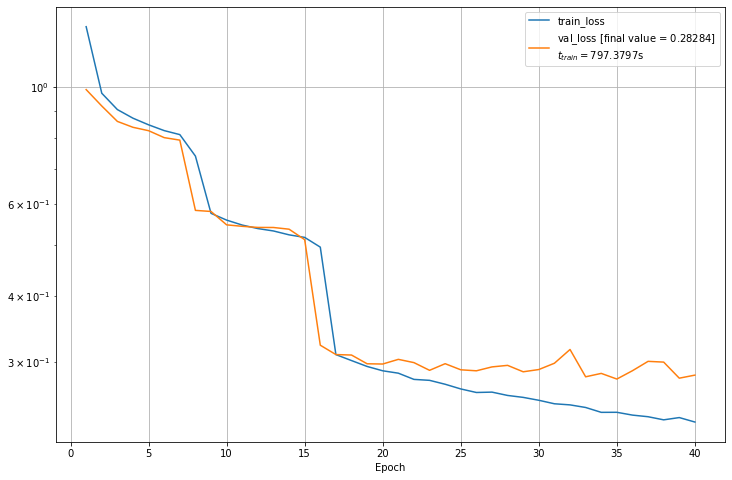

In [ ]:
plt.figure(figsize=(12,8))

tmp = f'train_loss'
plt.semilogy(range(1, len(t_loss)+1), t_loss, label=tmp)
tmp = f'val_loss ' + '[final value = ' + f'${v_loss[-1]:.5f}$]' + '\n' + '$t_{train}=$' + f'{(end-start):.4f}s'
plt.semilogy(range(1, len(v_loss)+1), v_loss, label=tmp)

plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Re-load the dataset

transf = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True, transform=transf)
test_dataset = torchvision.datasets.MNIST('classifier_data', train=False, download=True, transform=transf)

In [ ]:
print('---------------------------------------')
print('########## START OF TRAINING ##########')

start = time.time()

# Initialize the network
net = CNN()
net.to(device)

optimizer = optim.Adam(net.parameters(), lr=l_rate, weight_decay=w_decay)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=2)

# Training loop
t_loss, _ = training_loop(net, epochs, train_dataloader, [])

print(f'\nFinal training loss: {t_loss[-1]}')
end = time.time()
print(f'Elapsed time: {end-start}s')

print('########### END OF TRAINING ###########')
print('---------------------------------------')

---------------------------------------
########## START OF TRAINING ##########
......EPOCH 1/40
Train loss: 1.5714647769927979
......EPOCH 6/40
Train loss: 1.0511900186538696
......EPOCH 11/40
Train loss: 0.9950084090232849
......EPOCH 16/40
Train loss: 0.7458258867263794
......EPOCH 21/40
Train loss: 0.2832862436771393
......EPOCH 26/40
Train loss: 0.2600959241390228
......EPOCH 31/40
Train loss: 0.24561670422554016
......EPOCH 36/40
Train loss: 0.22941742837429047

Final training loss: 0.21931906044483185
Elapsed time: 638.0402853488922s
########### END OF TRAINING ###########
---------------------------------------


In [ ]:
net_state_dict = net.state_dict()
torch.save(net_state_dict, 'classification_model_CNN.torch')

In [ ]:
# Network input (the test set)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True, num_workers=2)

# Network output
predictions = []
net.to(device)
net.eval()
with torch.no_grad():
  for sample_batched in test_dataloader:
    # Move data to device
    x_batched = sample_batched[0].to(device)
    label_batched = sample_batched[1].to(device)

    # Forward pass
    out = net(x_batched).squeeze().cpu()
    predictions.append([sample_batched, F.softmax(out, dim=1)])

In [ ]:
y_true = []
y_pred = []
images = []
y_pred_prob = []

for batch in predictions:
  # batch[0][0] : (128) images in one batch
  # batch[0][1] : (128) ground truths of the batch
  # batch[1] : (128) predictions for the batch
  for (img, gt, pred) in zip(batch[0][0], batch[0][1], batch[1]):
    y_pred.append((int)(np.argmax(pred)))
    y_true.append((int)(gt))
    images.append(np.array(img))
    y_pred_prob.append(pred)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
images = np.array(images)
y_pred_prob = np.array(y_pred_prob, dtype='object')

corr_pred = (y_true == y_pred)
print(f'Number of correct predictions: {sum(corr_pred)}/{len(corr_pred)} ({100 * sum(corr_pred)/len(corr_pred)}%)\n')

prec, rec, fscore, supp = precision_recall_fscore_support(y_true, y_pred)

print('F1 score')
for i in range(n_classes):
  print(f'Class {i}: {fscore[i]:.4f}')

print('\nConfusion matrix (row - true, column - predicted):')
print(confusion_matrix(y_true, y_pred))

Number of correct predictions: 8888/10000 (88.88%)

F1 score
Class 0: 0.8296
Class 1: 0.9790
Class 2: 0.8243
Class 3: 0.8900
Class 4: 0.8099
Class 5: 0.9714
Class 6: 0.7124
Class 7: 0.9490
Class 8: 0.9715
Class 9: 0.9561

Confusion matrix (row - true, column - predicted):
[[818   1  22  21   5   2 122   0   9   0]
 [  4 978   3   9   2   0   3   0   1   0]
 [ 12   1 854   7  54   0  70   0   2   0]
 [ 27  13   7 874  30   0  47   0   2   0]
 [  0   1 101  28 769   0  98   0   3   0]
 [  0   0   0   0   0 967   0  21   0  12]
 [108   3  80  17  38   0 743   0  11   0]
 [  0   0   0   0   0  11   0 967   0  22]
 [  3   1   5   8   1   5   2   4 971   0]
 [  0   0   0   0   0   6   1  46   0 947]]


In [ ]:
y_true_c = y_true[corr_pred]
y_pred_c = y_pred[corr_pred]
images_c = images[corr_pred]
y_pred_prob_c = y_pred_prob[corr_pred]

wrong_pred = (y_true != y_pred)
y_true_w = y_true[wrong_pred]
y_pred_w = y_pred[wrong_pred]
images_w = images[wrong_pred]
y_pred_prob_w = y_pred_prob[wrong_pred]

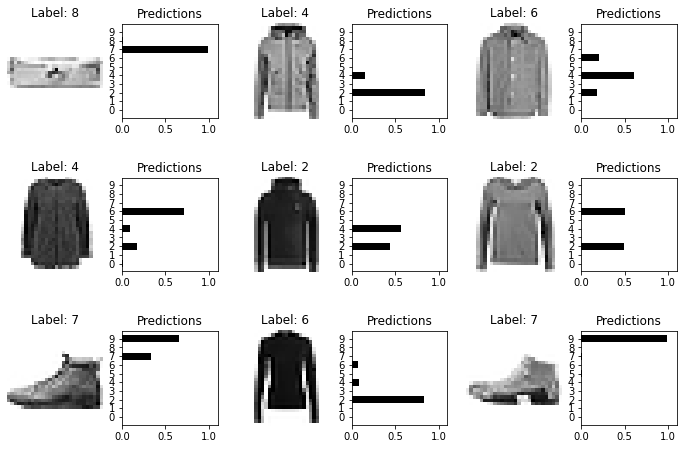

In [ ]:
fig, ax = plt.subplots(3, 6, figsize=(12,8))

for i in range(3):
  for j in [0, 2, 4]:
    index = np.random.randint(0, len(y_true_w))
    ax[i, j].imshow(images_w[index].squeeze(), cmap='Greys')
    ax[i, j].set_title(f'Label: {y_true_w[index]}')
    ax[i, j].axis('off')
    ax[i, j+1].barh(np.arange(10), y_pred_prob_w[index], color='black')
    ax[i, j+1].set_aspect(0.1)
    ax[i, j+1].set_yticks(np.arange(10))
    ax[i, j+1].set_yticklabels(np.arange(10))
    ax[i, j+1].set_title('Predictions')
    ax[i, j+1].set_xlim(0, 1.1)

plt.show()

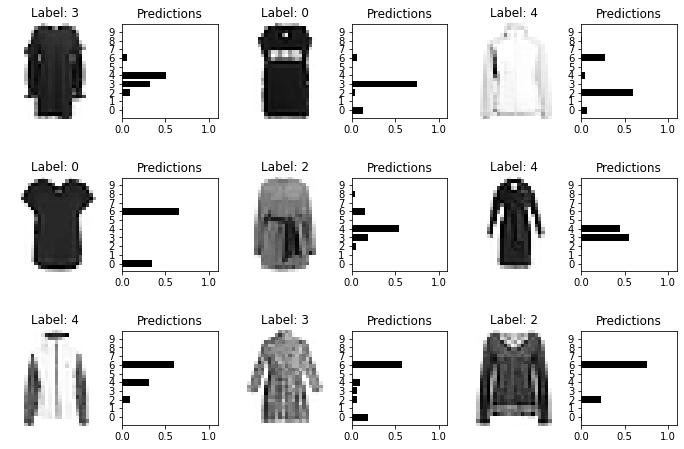

In [ ]:
fig, ax = plt.subplots(3, 6, figsize=(12,8))

for i in range(3):
  for j in [0, 2, 4]:
    index = np.random.randint(0, len(y_true_w))
    ax[i, j].imshow(images_w[index].squeeze(), cmap='Greys')
    ax[i, j].set_title(f'Label: {y_true_w[index]}')
    ax[i, j].axis('off')
    ax[i, j+1].barh(np.arange(10), y_pred_prob_w[index], color='black')
    ax[i, j+1].set_aspect(0.1)
    ax[i, j+1].set_yticks(np.arange(10))
    ax[i, j+1].set_yticklabels(np.arange(10))
    ax[i, j+1].set_title('Predictions')
    ax[i, j+1].set_xlim(0, 1.1)

plt.show()

In [ ]:
con_mat_cnn = confusion_matrix(y_true, y_pred)
display(con_mat_cnn)

array([[818,   1,  22,  21,   5,   2, 122,   0,   9,   0],
       [  4, 978,   3,   9,   2,   0,   3,   0,   1,   0],
       [ 12,   1, 854,   7,  54,   0,  70,   0,   2,   0],
       [ 27,  13,   7, 874,  30,   0,  47,   0,   2,   0],
       [  0,   1, 101,  28, 769,   0,  98,   0,   3,   0],
       [  0,   0,   0,   0,   0, 967,   0,  21,   0,  12],
       [108,   3,  80,  17,  38,   0, 743,   0,  11,   0],
       [  0,   0,   0,   0,   0,  11,   0, 967,   0,  22],
       [  3,   1,   5,   8,   1,   5,   2,   4, 971,   0],
       [  0,   0,   0,   0,   0,   6,   1,  46,   0, 947]])

Confusion Matrix=:>


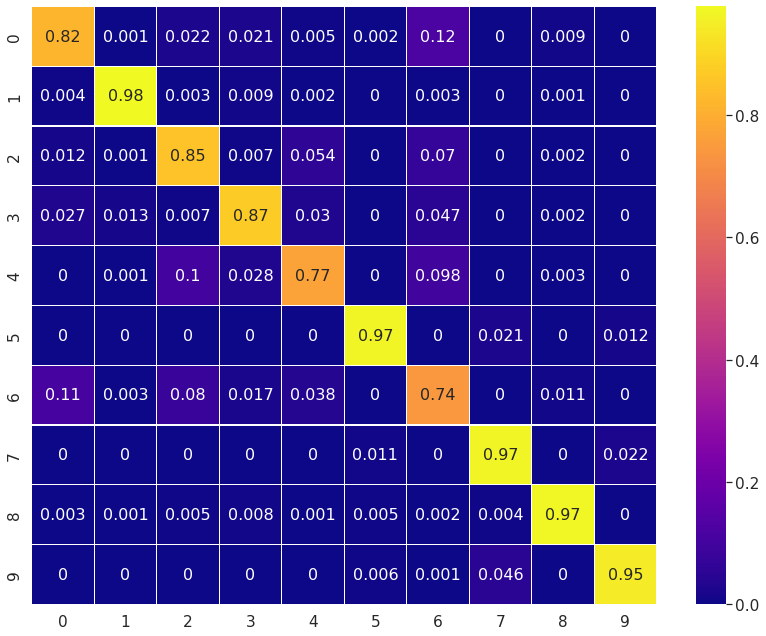

In [ ]:
print('Confusion Matrix=:>')
con_mat = con_mat_cnn.astype('float') / con_mat_cnn.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(14,11))
sns.set(font_scale=1.4)
sns.heatmap(con_mat, annot=True, annot_kws={'size': 16}, cmap='plasma', linewidths=0.2)
#class_name = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
#tick_marks = np.arange(len(len(y_true_w)))
#tick_marks2 = tick_maks+0.5
plt.xticks()
plt.yticks()
plt.show()

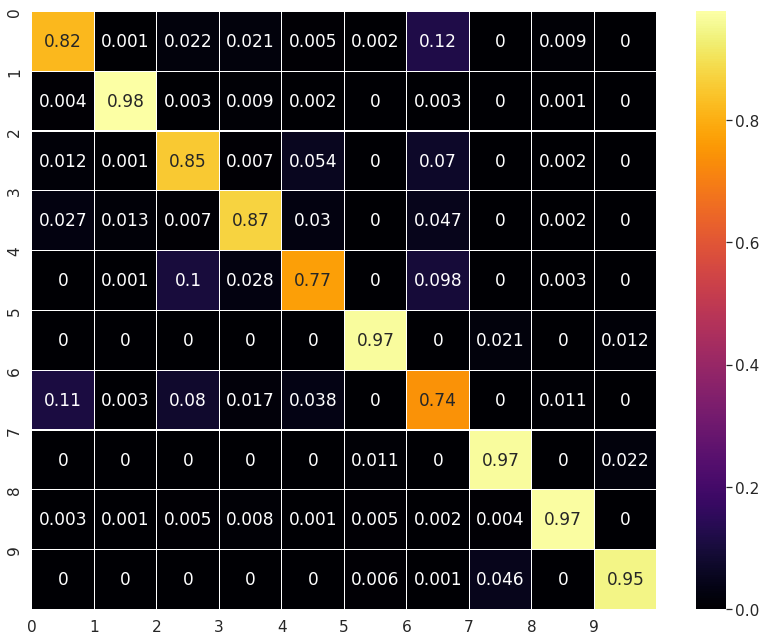

In [ ]:
con_mat = con_mat_cnn.astype('float') / con_mat_cnn.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(14,11))
sns.set(font_scale=1.4)
sns.heatmap(con_mat, annot=True, annot_kws={'size': 17}, cmap='inferno', linewidths=0.2)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.show()

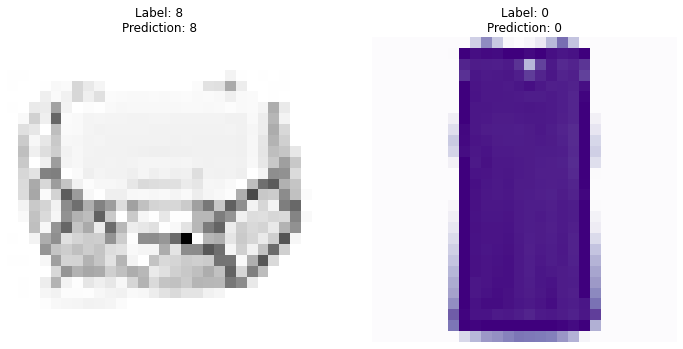

In [ ]:
# Get two images
index1 = np.random.randint(0, len(y_true))
index2 = np.random.randint(0, len(y_true))

img1 = images[index1].squeeze()
label1 = y_true[index1]
img2 = images[index2].squeeze()
label2 = y_true[index2]

fig, ax = plt.subplots(1, 2, figsize=(12,8))
ax[0].imshow(img1, cmap='Greys')
tmp1 = f'Label: {label1}\n'
ax[0].axis('off')
ax[1].imshow(img2, cmap='Purples')
tmp2 = f'Label: {label2}\n'
ax[1].axis('off')

img1 = np.reshape(img1, (1, 1, img1.shape[0], img1.shape[1]))
img2 = np.reshape(img2, (1, 1, img2.shape[0], img2.shape[1]))

# Evaluation
net.to(device)
net.eval()
with torch.no_grad():
  # Move data to device
  x_batched1 = torch.from_numpy(img1).to(device)
  x_batched2 = torch.from_numpy(img2).to(device)

  # Forward pass
  out1, out11, out21, out31 = net.forward(x_batched1, True)
  out1 = out1.squeeze().cpu()
  out11 = out11.squeeze().cpu()
  out21 = out21.squeeze().cpu()
  out31 = out31.squeeze().cpu()
  out2, out12, out22, out32 = net.forward(x_batched2, True)
  out2 = out2.squeeze().cpu()
  out12 = out12.squeeze().cpu()
  out22 = out22.squeeze().cpu()
  out32 = out32.squeeze().cpu()

pred1 = F.softmax(out1, dim=0)
pred2 = F.softmax(out2, dim=0)

tmp1 = tmp1 + f'Prediction: {np.argmax(pred1)}'
ax[0].set_title(tmp1)
tmp2 = tmp2 + f'Prediction: {np.argmax(pred2)}'
ax[1].set_title(tmp2)

plt.show()

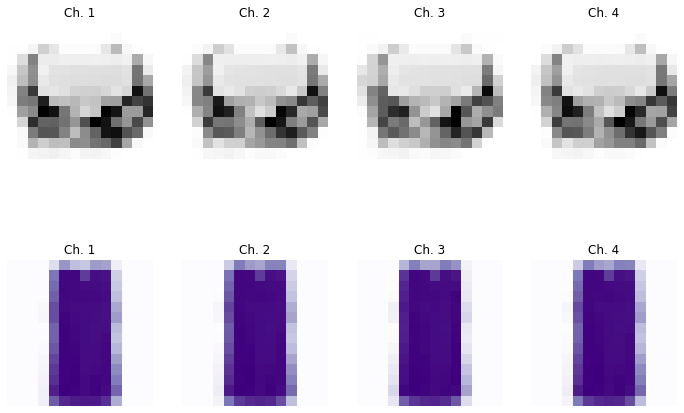

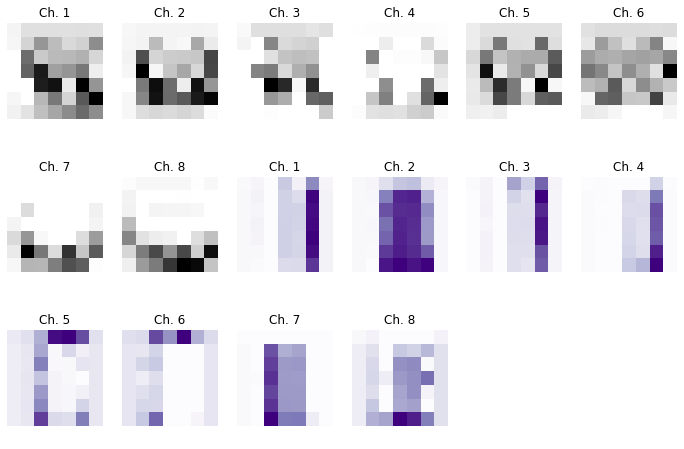

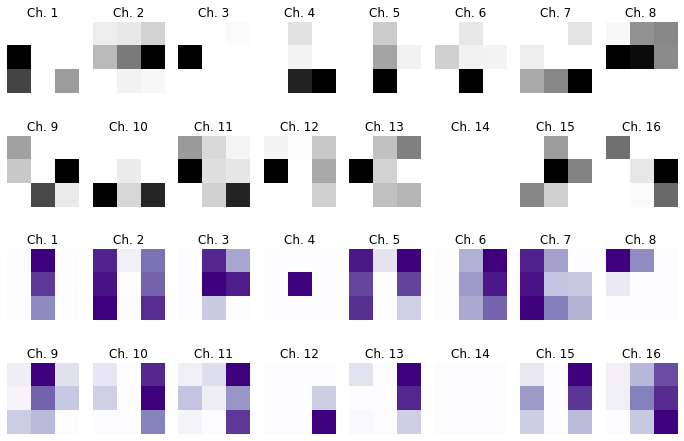

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(12,8))

c = 0
for i in range(2):
  for j in range(4):
    if c < 4:
      ax[i, j].imshow(out11[c], cmap='Greys')
      ax[i, j].set_title(f'Ch. {c+1}')
    else:
      ax[i, j].imshow(out12[c-4], cmap='Purples')
      ax[i, j].set_title(f'Ch. {c-4+1}')

    ax[i, j].axis('off')
    c = c+1

plt.show()

fig, ax = plt.subplots(3, 6, figsize=(12,8))

c = 0
for i in range(3):
  for j in range(6):
    if c < 16:
      if c < 8:
        ax[i, j].imshow(out21[c], cmap='Greys')
        ax[i, j].set_title(f'Ch. {c+1}')
      else:
        ax[i, j].imshow(out22[c-8], cmap='Purples')
        ax[i, j].set_title(f'Ch. {c-8+1}')

      c = c+1
    ax[i, j].axis('off')

plt.show()

fig, ax = plt.subplots(4, 8, figsize=(12,8))

c = 0
for i in range(4):
  for j in range(8):
    if c < 16:
      ax[i, j].imshow(out31[c], cmap='Greys')
      ax[i, j].set_title(f'Ch. {c+1}')
    else:
      ax[i, j].imshow(out32[c-16], cmap='Purples')
      ax[i, j].set_title(f'Ch. {c-16+1}')

    ax[i, j].axis('off')
    c = c+1

plt.show()

plt.show()

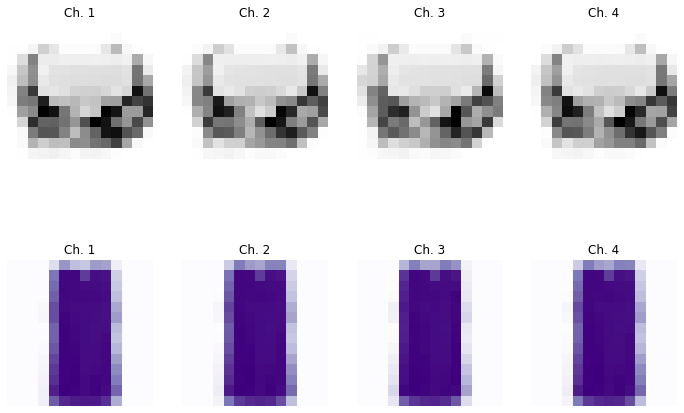

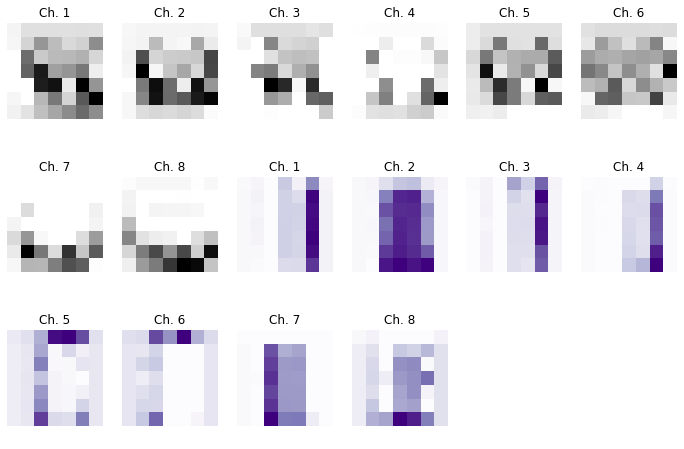

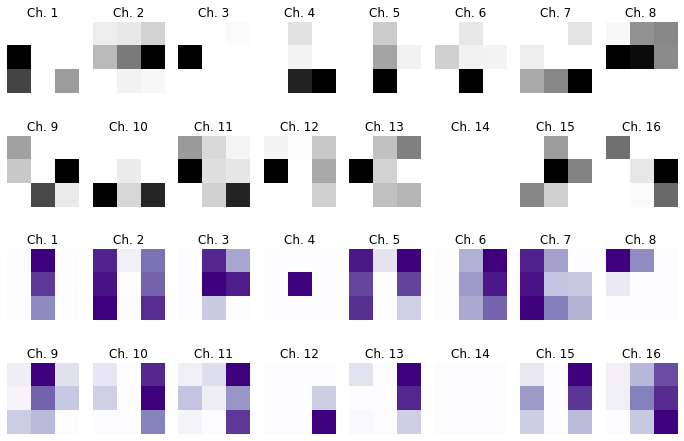

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(12,8))

c = 0
for i in range(2):
  for j in range(4):
    if c < 4:
      ax[i, j].imshow(out11[c], cmap='Greys')
      ax[i, j].set_title(f'Ch. {c+1}')
    else:
      ax[i, j].imshow(out12[c-4], cmap='Purples')
      ax[i, j].set_title(f'Ch. {c-4+1}')

    ax[i, j].axis('off')
    c = c+1

plt.show()

fig, ax = plt.subplots(3, 6, figsize=(12,8))

c = 0
for i in range(3):
  for j in range(6):
    if c < 16:
      if c < 8:
        ax[i, j].imshow(out21[c], cmap='Greys')
        ax[i, j].set_title(f'Ch. {c+1}')
      else:
        ax[i, j].imshow(out22[c-8], cmap='Purples')
        ax[i, j].set_title(f'Ch. {c-8+1}')

      c = c+1
    ax[i, j].axis('off')

plt.show()

fig, ax = plt.subplots(4, 8, figsize=(12,8))

c = 0
for i in range(4):
  for j in range(8):
    if c < 16:
      ax[i, j].imshow(out31[c], cmap='Greys')
      ax[i, j].set_title(f'Ch. {c+1}')
    else:
      ax[i, j].imshow(out32[c-16], cmap='Purples')
      ax[i, j].set_title(f'Ch. {c-16+1}')

    ax[i, j].axis('off')
    c = c+1

plt.show()

plt.show()

In [ ]:
2+2

4

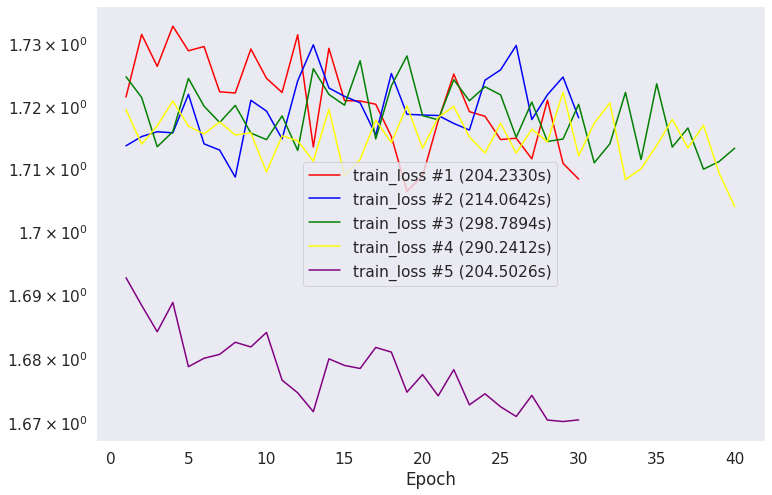

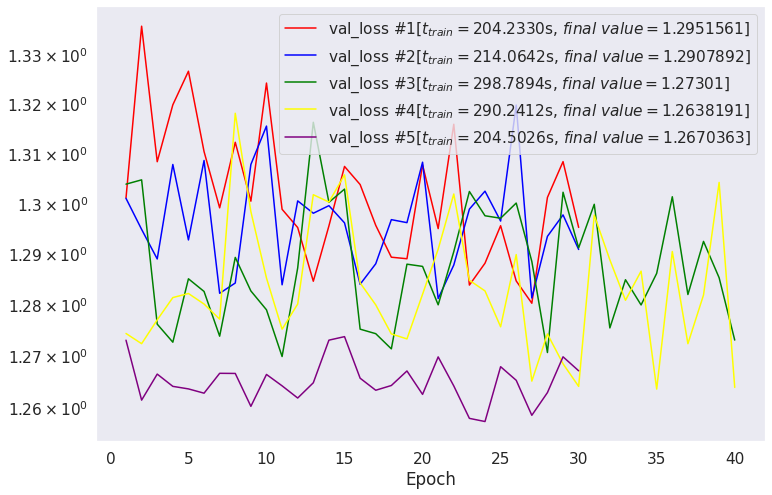

In [ ]:
plt.figure(figsize=(12,8))

colors = ['red', 'blue', 'green', 'yellow', 'purple']

for j in range(0, len(train_l)):
	tmp = f'train_loss #{j+1} ({times[j]:.4f}s)'
	plt.semilogy(range(1, len(train_l[j])+1), train_l[j], color=colors[j], label=tmp)

plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(12,8))

for j in range(0, len(val_l)):
	tmp = f'val_loss #{j+1}' + '[$t_{train}=$' + f'{times[j]:.4f}s, $final\ value =${(val_l[j])[-1]}]'
	plt.semilogy(range(1, len(val_l[j])+1), val_l[j], color=colors[j], label=tmp)

plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()